In [261]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Enviorment build up

**1.1 Import helpful libraries**

In [262]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math

**1.2 Load and Show the data**

In [263]:
file_path = '../input/25000-canadian-rental-housing-market-june-2024/rentfaster.csv'
# try to read the file from the kaggle input
try:
    # load the data from the kaggle input
    original_data = pd.read_csv(file_path)
except FileNotFoundError:
    # if the file is not found, read the file from the local file   
    file_path = 'rentfaster.csv'
    original_data = pd.read_csv(file_path)
    
print("Overview of the DataFrame, including data types and non-null counts: \n")
original_data.info()

Overview of the DataFrame, including data types and non-null counts: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25771 entries, 0 to 25770
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rentfaster_id      25771 non-null  int64  
 1   city               25771 non-null  object 
 2   province           25771 non-null  object 
 3   address            25646 non-null  object 
 4   latitude           25771 non-null  float64
 5   longitude          25771 non-null  float64
 6   lease_term         25725 non-null  object 
 7   type               25771 non-null  object 
 8   price              25771 non-null  float64
 9   beds               25639 non-null  object 
 10  baths              25637 non-null  object 
 11  sq_feet            21659 non-null  object 
 12  link               25771 non-null  object 
 13  furnishing         25771 non-null  object 
 14  availability_date  25759 non-null  object 
 15 

In [264]:
original_data.head()

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
0,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
1,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2695.0,3 Beds,2.5,1496,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
2,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2295.0,2 Beds,2.5,1180,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
3,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2095.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,November 18,Non-Smoking,True,True
4,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True


**1.3 Build a simple model for the set up**
    
    **This model is not use for the final use, it only using for find the best model**

In [265]:
# drop the row that missing the target value, price
# Drop rows with missing values in the 'price' column
print(original_data.columns)


def split_data():
    original_data.dropna(axis=0, subset=['price'], inplace=True)

    # Separate the target variable
    y = original_data.price

    # Separate the features
    X = original_data.drop(['price'], axis=1)

    # split the dataset
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Further split the train+validation set into separate train and validation sets (e.g., 75% train, 25% validation)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data()


Index(['rentfaster_id', 'city', 'province', 'address', 'latitude', 'longitude',
       'lease_term', 'type', 'price', 'beds', 'baths', 'sq_feet', 'link',
       'furnishing', 'availability_date', 'smoking', 'cats', 'dogs'],
      dtype='object')


In [266]:
# function just for test the dataset score
def score_dataset(X_train, X_valid, y_train, y_valid,model_class=RandomForestRegressor):
    model = model_class()
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

# 2. Handle the Categorical Variables
1. Drop Categorical Variables
2. Ordinal Encoding
3. One-Hot Encoding

**2.1 Determine the number of categorical variables present and consider the impact of removing them entirely.**

In [267]:
# get columns with categorical variable
s = (X_train.dtypes == 'object')
print(f"Categorical variables, the True means Categorical, else otherwise:\n\n{s}\n")
object_cols = list(s[s].index)

print(f"The percentage of the Categorical variables over All variables: {round((len(object_cols) / len(original_data.columns)), 2)}\n\n")

# approach 1 drop categorical variablesb  
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_val.select_dtypes(exclude=['object'])

print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_val))

Categorical variables, the True means Categorical, else otherwise:

rentfaster_id        False
city                  True
province              True
address               True
latitude             False
longitude            False
lease_term            True
type                  True
beds                  True
baths                 True
sq_feet               True
link                  True
furnishing            True
availability_date     True
smoking               True
cats                  True
dogs                  True
dtype: bool

The percentage of the Categorical variables over All variables: 0.78


MAE from Approach 1 (Drop categorical variables):
398.39346770371276


> Approximately 78% of the features are categorical variables, meaning that if we ignore all of them, only about 22% of the data would remain, rendering the training process meaningless. Therefore, we cannot simply drop all categorical variables. However, in future analysis, we may consider removing some less meaningful categorical columns to streamline the dataset.

**2.2 Find out the count of unique elements for each categorical column**

In [268]:
def get_unique_elements_per_column(original_data, object_cols):
    """
    Returns a dictionary with the count of unique elements for each categorical column.

    Parameters:
    - original_data: DataFrame containing the data.
    - object_cols: List of column names that are categorical.

    Returns:
    - A dictionary where keys are column names and values are the number of unique elements in each column.
    """

    # get the details of the unique element in each columns
    unique_number_of_categorical_list = list(map(lambda col: original_data[col].nunique(), object_cols))

    # present by dictionary
    unique_number_of_categorical_dict = dict(zip(object_cols,unique_number_of_categorical_list))
    return unique_number_of_categorical_dict
    
print(f"The unique element in each columns is: \n {get_unique_elements_per_column(original_data, object_cols)}")

The unique element in each columns is: 
 {'city': 269, 'province': 10, 'address': 8002, 'lease_term': 6, 'type': 15, 'beds': 11, 'baths': 17, 'sq_feet': 1896, 'link': 9615, 'furnishing': 4, 'availability_date': 132, 'smoking': 4, 'cats': 2, 'dogs': 2}


> 1. The addresses vary widely, so consider removing the entire column or just the street numbers.
> 2. The link field is unnecessary, as it only provides information about one location.
> 3. Simplify availability_date to two categories, as specific dates aren't needed.
> 4. Certain data should be numeric rather than categorical. For example, fields like beds, baths, and square feet need to be converted to numeric values.
> 5. smoking column to binary format, where 0 represents "no smoking allowed" and 1 represents "smoking allowed.
> 6. cats/dogs column to binary format, where 0 represents "not allowed" and 1 represents "allowed.

**2.3.1 Remove the address number**

In [269]:
original_copy = original_data.copy()

# 1.show the address number
print(f"Before remove the address number:\n\n{original_copy.address.head()}\nnumber of unique: {original_copy.address.nunique()}\n\n")

# Remove the address number using regular expression
original_data["address"] = list(map(lambda x: re.sub(r'^\d+\s+', '', str(x)), original_copy.address))
print(f"After remove the address number:\n\n{original_copy.address.head()}\nnumber of unique: {original_copy.address.nunique()}\n\n")


Before remove the address number:

0    69 Gateway Dr NE
1    69 Gateway Dr NE
2    69 Gateway Dr NE
3    69 Gateway Dr NE
4    69 Gateway Dr NE
Name: address, dtype: object
number of unique: 8002


After remove the address number:

0    69 Gateway Dr NE
1    69 Gateway Dr NE
2    69 Gateway Dr NE
3    69 Gateway Dr NE
4    69 Gateway Dr NE
Name: address, dtype: object
number of unique: 8002




> > ummm, still too many, we might need another way to deal with it, or just simply delete it

**2.3.2 remove link column**

In [270]:
original_data = original_data.drop(columns=["link"])

print(original_data.columns)

Index(['rentfaster_id', 'city', 'province', 'address', 'latitude', 'longitude',
       'lease_term', 'type', 'price', 'beds', 'baths', 'sq_feet', 'furnishing',
       'availability_date', 'smoking', 'cats', 'dogs'],
      dtype='object')


**2.3.4 Convert and Handel the numeric variables**

In [271]:
def get_unique_values(original_data, features):
    """
    Returns unique values for specified features in a DataFrame.

    Parameters:
    original_data: The DataFrame containing the data.
    features (list): A list of column names to find unique values for.

    Returns:
    dict: A dictionary with column names as keys and arrays of unique values as values.
    """
    
    unique_values = {}
    
    # get a 2d array, contains 3 features' unique value
    list_of_features_unique_value = list(map(lambda feature: original_data[feature].unique(), features))
    
    unique_values = dict(zip(features, list_of_features_unique_value))

    return unique_values

# Find out the unique_values for each features
unique_values = get_unique_values(original_data, ['baths', 'beds', 'sq_feet'])
for unique in unique_values:
    print(f"{unique}: {unique_values[unique]},\n{unique} has {len(unique_values[unique])} uniques\n")

# original_copy.baths = list(map(lambda x: float(x) if x != "none" else 0, original_copy.baths))

# original_copy['baths'] = pd.to_numeric(original_copy['baths'], errors='coerce')
# print(original_copy.baths)


baths: ['2.5' '1' '2' '1.5' '3.5' nan '4' '3' '5' 'none' '4.5' '7.5' '5.5' '6'
 '6.5' '7' '8' '0'],
baths has 18 uniques

beds: ['2 Beds' '3 Beds' 'Studio' '1 Bed' '5 Beds' '4 Beds' nan '6 Beds'
 'none Beds' '8 Beds' '7 Beds' '9 Beds'],
beds has 12 uniques

sq_feet: ['1403' '1496' '1180' ... '260' '286' '334'],
sq_feet has 1897 uniques



> Beds and baths are straightforward, and any NaN or None values should be converted to 0. However, since square feet has 1,897 unique entries and many contain strings, we need to handle it more carefully

***Data Cleaning and Conversion of 'Baths' Column***

In [272]:
# baths: ['2.5' '1' '2' '1.5' '3.5' nan '4' '3' '5' 'none' '4.5' '7.5' '5.5' '6'
 #'6.5' '7' '8' '0'],
    
def clean_column(column_name,  cleaning_function):
    """
    Cleans the specified column in the DataFrame by converting non-numeric values
    to floats and handle the nan or string entries

    Parameters:
    - dataframe: The pandas DataFrame containing the data.
    - column_name: The name of the column to clean.
    - cleaning_function: A function that defines how to clean each value.

    The function prints the number of missing values before and after processing,
    displays the cleaned data, and confirms whether the conversion was successful.
    """
    
    before_num_of_missing = original_data[column_name].isnull().sum()
    # cleaning process is going on here!
    cleaning_function(column_name) 
    
    after_num_of_missing = original_data[column_name].isnull().sum()

    # '''Print the number of missing values before and after the conversion'''
    print(f"The number of missing before handle: {before_num_of_missing}")
    print(f"The number of missing after handle: {after_num_of_missing}\n")
    print(f"Bath data after cleaning:\n{original_data[column_name]}\n")

    # Check if conversion was successful (no missing values and correct dtype)
    if original_data[column_name].dtype != 'object' and after_num_of_missing == 0:
        print("Baths converted successfully with 0 missing values")
    else:
        print("Baths conversion failed")

        
# Convert values: replace "none" and NaN with 0, convert others to float        
def baths_cleaning(column_name):
    original_data[column_name] = original_data[column_name].map(
        lambda x: float(x) if x != "none" and not pd.isna(x) else 0
    )

clean_column('baths', baths_cleaning)

The number of missing before handle: 134
The number of missing after handle: 0

Bath data after cleaning:
0        2.5
1        2.5
2        2.5
3        2.5
4        2.5
        ... 
25766    1.0
25767    1.0
25768    1.0
25769    1.0
25770    1.0
Name: baths, Length: 25771, dtype: float64

Baths converted successfully with 0 missing values


***Data Cleaning and Conversion of 'Beds' Column***

In [273]:
# beds: ['2 Beds' '3 Beds' 'Studio' '1 Bed' '5 Beds' '4 Beds' nan '6 Beds'
 #'none Beds' '8 Beds' '7 Beds' '9 Beds'],


## Cleans and converts the beds column to integers.
def beds_cleaning(column_name):
    """
    This function cleans and converts the 'beds' column to integers.
    It handles various formats including:
    - '2 Beds', '3 Beds', etc.: Converted to their respective integer values
    - 'Studio': Converted to 0
    - 'none Beds': Converted to 0
    - NaN values: Converted to 0
    
    The function uses a helper function 'get_num_of_bed' to extract the numeric value
    from strings like '2 Beds' or '1 Bed'.
    """
    # Covert string value to integer
    def get_num_of_bad(value):
        value = value.replace("Beds", "").replace("Bed", "").strip()
        return int(value)
    
    original_data[column_name] = original_data[column_name].map(
        # Replaces 'none Beds' and 'Studio' with 0.
        lambda x: get_num_of_bad(x) if x != "none Beds"and x != "Studio" and not pd.isna(x) else 0 
    )
    
clean_column('beds', beds_cleaning)

The number of missing before handle: 132
The number of missing after handle: 0

Bath data after cleaning:
0        2
1        3
2        2
3        2
4        2
        ..
25766    0
25767    3
25768    1
25769    0
25770    2
Name: beds, Length: 25771, dtype: int64

Baths converted successfully with 0 missing values


***Data Cleaning and Conversion of 'sq_feet' Column***

In [274]:
def clean_sq_feet(value):
    """
    Cleans and converts the 'sq_feet' column to numeric values.

    This function handles various formats and special cases:
    1. Removes parentheses and their contents.
    2. Handles addition ('+') and multiplication ('*') operations:
       - For large numbers with addition (e.g., 1500900+600), it takes the first 4 or 5 digits.
       - Evaluates expressions like '2,150 + 950' or '10 * 12'.
    3. Handles ranges with hyphens ('-'):
       - Calculates the average of the range (e.g., '500-600' becomes 550).
       - For multiple hyphens, uses only the first and last number.
    4. Handles comma-separated values:
       - For multiple comma-separated values, sums them up.
       - For single comma as thousand separator, removes it.
    5. Removes non-numeric characters except '+', '-', '*', '.', and '×'.
    6. Replaces '×' with '*' for multiplication.
    7. Strips leading/trailing '+', '-', '*', and '.' characters.

    Special cases:
    - Handles professionally developed basements (e.g., '2,150 + 950 SF').
    - Manages multiple area descriptions (e.g., '1300 sft Basement, 350 sft Master bedroom').

    Returns:
    float: The cleaned and converted square footage value.
    """
    # Function implementation follows...

    # Remove parentheses and their contents
    value = re.sub(r'\([^)]*\)', '', value)

    # Remove any non-numeric characters except '+' and '-' and "*" and "." and "×"
    value = re.sub(r'[^\d+\-*.,×]', '', value)

    # replace specical mulitiplation sign
    value = value.replace("×", '*')
    
    # Handle cases with '+' or '-' at the beginning or end
    value = value.strip('+-*.')
    
    # If there's a '+', '*' evaluate the expression
    if '+' in value or '*' in value:
        # Handle large numbers with addition
        # eg, 1500900+600 happened in index series[13651], it means 1500 = 900 + 600
        if '+' in value:
            # remove , in the addition case,
            # eg, 2,150 + 950 SF (professionally developed basement)
            value = value.replace(",", "")
            parts = value.split('+')
            if len(parts[0]) > 4:  # If the first part is a large number (more than 4 digits)
                if len(parts[1]) == 4 and len(parts[0]) == 9:
                    return float(parts[0][:5])  # Return the first 5 digits of the large number
                elif len(parts[1]) == 5:
                    return float(parts[0][:5])  # Return the first 5 digits of the large number
                else:
                    return float(parts[0][:4])  # Return the first 4 digits of the large number
        # rest are '+' and '*'
        return float(eval(value))
    
    # if there's a '-', find the avergae
    elif '-' in value:
        # If there's more than one '-', keep only the first and last number
        if value.count('-') > 1:
            numbers = value.split('-')
            value = f"{numbers[0]}-{numbers[-1]}"
        return sum(map(float, value.split('-'))) / 2
    
    elif ',' in value:
        # Handle cases with commas
        if value.count(',') > 1:
            # Example: "1300 sft Basement, 350 sft Master bedroom, 800 sft Living and Dinning Room"
            # Replace commas with plus signs and strip any leading/trailing plus signs or commas
            value = value.replace(",", "+").strip("+,")
            # Return the total area as a float
            return float(eval(value))
        else:
            # 800 sqft for Condo, 150 sqft for balcony
            # 800, 150
            if len(value.split(',')[0]) > 2:
                 value = value.replace(",", "+").strip("+,")
                 return float(eval(value))
            
            # If there's only one comma, it's likely a thousands separator
            # Remove the comma and convert to float
            return float(value.replace(",", ''))
    
    # eg, 1200 s.f. up & 1000 s.f. developed lower level, 1200..1000
    elif value.count('.') > 1:
        # Convert all '.' to '+', and if '..' are together, make it one '+'
        value = value.replace('.', '+')
        # Remove any consecutive '+' signs
        # "1++2" would become "1+2"
        value = re.sub(r'\++', '+', value)
        # Strip any leading/trailing '+' signs
        value = value.strip('+')
        # Evaluate the expression
        return float(eval(value))
    
    # 1100 up and 1100 down
    # 11001100
    if len(value) > 4:
        return float(value[:4])

    # If it's a simple number, convert to int
    return float(value) if value != "" else 0

   

series = original_data.sq_feet.copy()
# # test here
# print(series[3647])
series = series.astype(str)
series = series.apply(clean_sq_feet)


# check the any remain dirty data
special_entries = []
for index, value in enumerate(series):
    if not isinstance(value, (int, float)) or math.isnan(value):  # Check if value is not a number or is NaN
        special_entries.append((value, index))
        print(f"Non-numeric value found: '{value}' at index {index}")

# Check if there are any remaining special entries (non-numeric or NaN values)
# If none are found, it means all sq_feet data has been successfully cleaned
if len(special_entries) == 0:
    '''
    update the cleaned data to the original_data
    '''
    original_data['sq_feet'] = series
    print("The 'sq_feet' column in original_data has been updated with the cleaned data.")
    
    # Print status of the series
    print("Status of the sq_feet series:")
    print(f"Maximum value: {series.max()} at index {series.idxmax()}")
    print(f"Minimum value: {series.min()}")
    print(f"Number of entries: {len(series)}")
    print(f"Data type: {series.dtype}")




The 'sq_feet' column in original_data has been updated with the cleaned data.
Status of the sq_feet series:
Maximum value: 20400.0 at index 3647
Minimum value: 0.0
Number of entries: 25771
Data type: float64


**Show baths, beds, and sq_feet features unique again**


In [275]:
unique_values = get_unique_values(original_data, ['baths', 'beds', 'sq_feet'])
for unique in unique_values:
    print(f"{unique}: {unique_values[unique]},\n{unique} has {len(unique_values[unique])} uniques\n")

baths: [2.5 1.  2.  1.5 3.5 0.  4.  3.  5.  4.5 7.5 5.5 6.  6.5 7.  8. ],
baths has 16 uniques

beds: [2 3 0 1 5 4 6 8 7 9],
beds has 10 uniques

sq_feet: [1403. 1496. 1180. ...  260.  286.  334.],
sq_feet has 1630 uniques



**2.3.5 Convert the "smoking" category to a numerical format.** 

In [276]:
# Define a function to convert values to numerical format
def smoke_convert(value):
    # Convert values to integers based on their index in the list
    # Ranked the level of the smoking available, non-smoking < Negotiable < nan < Smoke Free Building < Smoking Allowed
    # from level 0 to level 4
    return int(['Non-Smoking', 'Negotiable', "nan", "Smoke Free Building", 'Smoking Allowed'].index(value))



def convert_column_to_numerical(column_name, convert_func):
    # Get unique values in the column
    unique_values = get_unique_values(original_data, [column_name])
    # Print unique values and their counts
    for unique in unique_values:
        print(f"{unique}: {unique_values[unique]},\n{unique} has {len(unique_values[unique])} uniques\n")


    # Update the column in the original data with the converted values
    # convert to str first in order to identify nan value
    original_data[column_name] = original_data[column_name].astype(str).apply(convert_func)

    print(f"{column_name} convertion complete!")
    print(f"Status of the {column_name} series:")
    print(f"Number of entries: {len(original_data[column_name])}")
    print(f"Data type: {original_data[column_name].dtype}\n\n")

# Call the function for the 'smoking' column
convert_column_to_numerical('smoking', smoke_convert)


smoking: ['Non-Smoking' 'Smoke Free Building' nan 'Negotiable' 'Smoking Allowed'],
smoking has 5 uniques

smoking convertion complete!
Status of the smoking series:
Number of entries: 25771
Data type: int64




**2.3.6 Convert the "dogs/cat" category to a numerical format.**

In [277]:
# Define a function to convert pet-related values to numerical format
def pet_convert(value):
    # Convert values to integers based on their index in the list
    # Ranked as: False (0) < nan (1) < True (2)
    # This represents: No pets allowed (0) < Unknown/Unspecified (1) < Pets allowed (2)
    return int(['False', "nan", 'True'].index(value))

# Apply the pet_convert function to 'dogs' and 'cats' columns
convert_column_to_numerical('dogs', pet_convert)
convert_column_to_numerical('cats', pet_convert)

dogs: [True False nan],
dogs has 3 uniques

dogs convertion complete!
Status of the dogs series:
Number of entries: 25771
Data type: int64


cats: [True False nan],
cats has 3 uniques

cats convertion complete!
Status of the cats series:
Number of entries: 25771
Data type: int64




In [278]:


# # Make copy to avoid changing original data 
# label_X_train = X_train.copy()
# label_X_valid = X_val.copy()

# # Apply ordinal encoder to each column with categorical data
# ordinal_encoder = OrdinalEncoder()
# label_X_train[object_cols] = ordinal_encoder.fit_transform(label_X_train[object_cols])
# label_X_valid[object_cols] = ordinal_encoder.transform(label_X_valid[object_cols])

# print("MAE from Approach 2 (Ordinal Encoding):") 
# print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

# 3. Handle the missing variables
1. Drop Columns with Missing Values¶
2. Imputation fills in the missing values with some number. In this case, we fill in the mean value along each column.
3. An Extension To Imputation

**3.1 Identify columns with missing values and calculate the details.**

In [279]:
def get_missing_value_details(dataframe):
    """
    Identify columns with missing values and calculate the details.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame to analyze.

    Returns:
    dict: A dictionary where keys are column names with missing values,
          and values are tuples containing the count and percentage of missing values.
    """
    # Get columns that have missing values
    cols_with_null = [col for col in dataframe.columns if dataframe[col].isnull().any()]

    # Calculate the sum and percentage of missing values for each column
    sum_of_cols_with_null = list(
        map(
            lambda col: (
                dataframe[col].isnull().sum(),  # Total number of missing values in the column
                "{:.5f}%".format(dataframe[col].isnull().sum() / len(dataframe) * 100)  # Percentage of missing values
            ),
            cols_with_null
        )
    )

    # Combine the column names with their respective missing value details into a dictionary    
    combined_missing_value_dict = dict(zip(cols_with_null, sum_of_cols_with_null))

    return combined_missing_value_dict


combined_missing_value_dict = get_missing_value_details(X_test)
print(f"Columns with missing values:\n{combined_missing_value_dict}")


Columns with missing values:
{'address': (28, '0.54316%'), 'lease_term': (9, '0.17459%'), 'beds': (25, '0.48497%'), 'baths': (25, '0.48497%'), 'sq_feet': (850, '16.48885%'), 'availability_date': (4, '0.07759%'), 'smoking': (553, '10.72745%'), 'cats': (31, '0.60136%'), 'dogs': (31, '0.60136%')}


> Since the column 'sq_feet' has the highest number of missing values at 850 cases, which is only 0.16489% of the entire dataset, removing the entire column is not advisable. Therefore, using imputation to handle these missing values would be a better approach


In [280]:
# try Impution to handle the missing value
imputer = SimpleImputer()
# handle_X_train = pd.DataFrame(imputer.fit_transform(X_train))
# handle_X_valid = pd.DataFrame(imputer.transform(X_val))

# check the dataset score after the imputer
print("MAE from Imputation:")
# print(score_dataset(handle_X_train, handle_X_valid, y_train, y_valid))

MAE from Imputation:


**3.2 Consider employing an alternative model to estimate the missing variable; for example, use the existing number of bedrooms and bathrooms to predict the square footage.**

**3.3 Try using mulit-imputation to handle the missing variable**

# 4. Visualize the data

array([[<Axes: title={'center': 'rentfaster_id'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>],
       [<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'beds'}>,
        <Axes: title={'center': 'baths'}>],
       [<Axes: title={'center': 'sq_feet'}>,
        <Axes: title={'center': 'smoking'}>,
        <Axes: title={'center': 'cats'}>],
       [<Axes: title={'center': 'dogs'}>, <Axes: >, <Axes: >]],
      dtype=object)

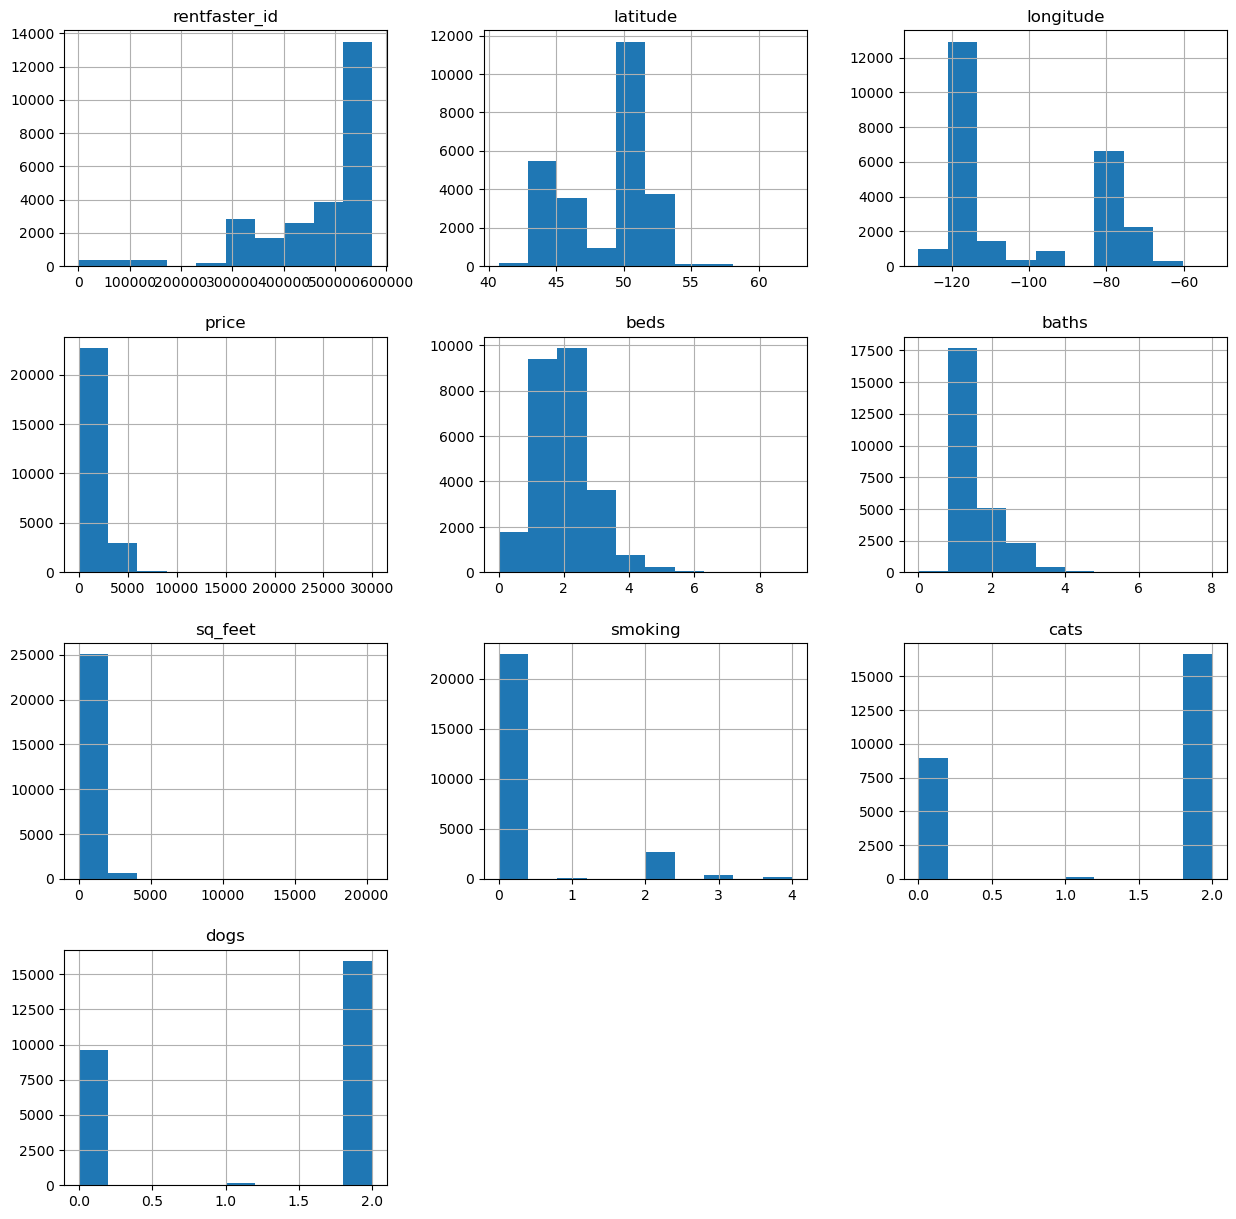

In [281]:
original_data.hist(figsize=(15, 15))